In [1]:
!pip -q install geopy pyarrow >/dev/null

import os, re, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

warnings.filterwarnings("ignore")


In [2]:
# --------------------------------
# FASE 1: EXTRACCIÓN
# --------------------------------
print("\n--- FASE 1: EXTRACCIÓN ---")
CSV_PATH = "/content/2025-07.csv"

if not os.path.exists(CSV_PATH):
    print("No se encontró /content/2025-07.csv. Sube tu CSV 👇")
    up = files.upload()
    CSV_PATH = next(iter(up.keys()))


try:
    df_raw = pd.read_csv(CSV_PATH)
except UnicodeDecodeError:
    df_raw = pd.read_csv(CSV_PATH, encoding="latin1")

print(f"Lectura OK: {CSV_PATH}")
print("Shape:", df_raw.shape)
display(df_raw.head())


--- FASE 1: EXTRACCIÓN ---
Lectura OK: /content/2025-07.csv
Shape: (1663896, 9)


,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_EstacionArribo,Fecha_Arribo,Hora_Arribo
0,M,30.0,4998803,173,30/06/2025,23:33:59,348,01/07/2025,00:00:11
1,M,27.0,3976669,009,30/06/2025,23:41:24,086,01/07/2025,00:00:21
2,M,43.0,8223240,576,30/06/2025,23:48:16,296,01/07/2025,00:00:24
3,M,26.0,6050157,365,30/06/2025,23:52:12,329,01/07/2025,00:00:27
4,M,23.0,5124706,144,30/06/2025,23:54:55,575,01/07/2025,00:00:46



--- FASE 2: TRANSFORMACIÓN ---

Columnas tras normalización (primeras 30):
['genero', 'Edad_Usuario', 'Bici', 'Ciclo_Estacion_Retiro', 'Fecha_Retiro', 'fecha_origen_recorrido', 'Ciclo_EstacionArribo', 'Fecha_Arribo', 'fecha_destino_recorrido']

Preview transformado:


,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,fecha_origen_recorrido,Ciclo_EstacionArribo,Fecha_Arribo,fecha_destino_recorrido,genero_?,genero_DESCONOCIDA,genero_F,genero_M,genero_O,duracion_minutos,dia_semana,hora_inicio,tipo_dia
0,30.0,4998803,173,30/06/2025,2025-08-19 23:33:59,348,01/07/2025,2025-08-19 00:00:11,False,False,False,True,False,-1413.800000,1,23,Entre Semana
1,27.0,3976669,009,30/06/2025,2025-08-19 23:41:24,086,01/07/2025,2025-08-19 00:00:21,False,False,False,True,False,-1421.050000,1,23,Entre Semana
2,43.0,8223240,576,30/06/2025,2025-08-19 23:48:16,296,01/07/2025,2025-08-19 00:00:24,False,False,False,True,False,-1427.866667,1,23,Entre Semana
3,26.0,6050157,365,30/06/2025,2025-08-19 23:52:12,329,01/07/2025,2025-08-19 00:00:27,False,False,False,True,False,-1431.750000,1,23,Entre Semana
4,23.0,5124706,144,30/06/2025,2025-08-19 23:54:55,575,01/07/2025,2025-08-19 00:00:46,False,False,False,True,False,-1434.150000,1,23,Entre Semana


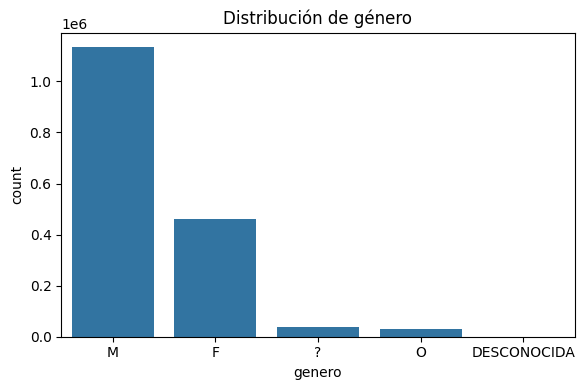

In [13]:


# --------------------------------
# FASE 2: TRANSFORMACIÓN
# --------------------------------
print("\n--- FASE 2: TRANSFORMACIÓN ---")
df = df_raw.copy()

# ---- 2.1 Normalización de nombres: detectar y renombrar columnas clave ----

aliases = {
    "fecha_origen_recorrido": [
        "fecha_origen_recorrido","fecha_inicio","inicio","start_time","started_at",
        "hora_retiro","fecha_hora_retiro","fecha_retiro","inicio_viaje","fecha_salida"
    ],
    "fecha_destino_recorrido": [
        "fecha_destino_recorrido","fecha_fin","fin","end_time","ended_at",
        "hora_arribo","fecha_hora_arribo","fecha_arribo","fin_viaje","fecha_llegada"
    ],
    "nombre_estacion_origen": [
        "nombre_estacion_origen","estacion_origen","origen","start_station_name",
        "nombre_estacion_salida","estacion_salida"
    ],
    "nombre_estacion_destino": [
        "nombre_estacion_destino","estacion_destino","destino","end_station_name",
        "nombre_estacion_llegada","estacion_llegada"
    ],
    "lat_estacion_origen": [
        "lat_estacion_origen","lat_origen","origen_lat","latitud_origen","lat_salida","start_lat"
    ],
    "long_estacion_origen": [
        "long_estacion_origen","lon_origen","long_origen","origen_lon","longitud_origen","lon_salida","start_lng","start_lon"
    ],
    "lat_estacion_destino": [
        "lat_estacion_destino","lat_destino","destino_lat","latitud_destino","lat_llegada","end_lat"
    ],
    "long_estacion_destino": [
        "long_estacion_destino","lon_destino","long_destino","destino_lon","longitud_destino","lon_llegada","end_lng","end_lon"
    ],
    "genero": [
        "genero","género","sexo","genero_usuario","sexo_usuario","gender"
    ],
    "modelo_bicicleta": [
        "modelo_bicicleta","tipo_bicicleta","tipo_bici","bike_model","bike_type"
    ],
    "duracion_recorrido": [
        "duracion_recorrido","duración_recorrido","duracion","tiempo_recorrido",
        "ride_length","trip_duration","duracion_min","duration_min","duracion_minutos"
    ],
}

lower_map = {c.lower(): c for c in df.columns}

def pick_col(candidates):
    # 1) match exacto por lower
    for cand in candidates:
        if cand.lower() in lower_map:
            return lower_map[cand.lower()]
    # 2) match por contiene
    for col in df.columns:
        cl = col.lower()
        if any(cand.lower() in cl for cand in candidates):
            return col
    return None

rename_ops = {}
for std, cands in aliases.items():
    real = pick_col(cands)
    if real and real != std:
        rename_ops[real] = std
if rename_ops:
    df = df.rename(columns=rename_ops)

print("\nColumnas tras normalización (primeras 30):")
print(list(df.columns)[:30])

# ---- 2.2 Fechas a datetime + duración en minutos ----

for c in ["fecha_origen_recorrido","fecha_destino_recorrido"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce", dayfirst=True, infer_datetime_format=True)



# ---- 2.3 Imputaciones simples ----
for c in ["nombre_estacion_origen","nombre_estacion_destino","modelo_bicicleta","genero"]:
    if c in df.columns:
        df[c] = df[c].fillna("DESCONOCIDA")

# Coordenadas a numérico
for c in ["lat_estacion_origen","long_estacion_origen","lat_estacion_destino","long_estacion_destino"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# ---- 2.4 One-Hot Encoding de 'genero' y 'modelo_bicicleta' (si existen) ----
df_enc = df.copy()
for col, pref in [("genero","genero"), ("modelo_bicicleta","modelo")]:
    if col in df_enc.columns:
        df_enc = pd.get_dummies(df_enc, columns=[col], prefix=[pref])

# ---- 2.5 Discretización de duración ----
if "duracion_recorrido" in df_enc.columns:
    bins = [0, 10, 20, 40, df_enc["duracion_recorrido"].max(skipna=True)]
    labels = ["Corto","Medio","Largo","Muy Largo"]
    df_enc["categoria_duracion"] = pd.cut(df_enc["duracion_recorrido"], bins=bins, labels=labels, right=False, include_lowest=True)

# ---- 2.6 Normalización (Min-Max) en numéricas clave (si existen) ----
num_cols = [c for c in [
    "duracion_recorrido","long_estacion_origen","lat_estacion_origen",
    "long_estacion_destino","lat_estacion_destino"
] if c in df_enc.columns]

if num_cols:
    scaler = MinMaxScaler()
    df_enc[num_cols] = scaler.fit_transform(df_enc[num_cols])

# ---- 2.7 Feature Engineering ----
if {"fecha_origen_recorrido","fecha_destino_recorrido"}.issubset(df_enc.columns):

    df_enc["fecha_origen_recorrido"] = pd.to_datetime(df_enc["fecha_origen_recorrido"], errors="coerce")
    df_enc["fecha_destino_recorrido"] = pd.to_datetime(df_enc["fecha_destino_recorrido"], errors="coerce")

    df_enc["duracion_minutos"] = (df_enc["fecha_destino_recorrido"] - df_enc["fecha_origen_recorrido"]).dt.total_seconds()/60.0
    df_enc["dia_semana"] = df_enc["fecha_origen_recorrido"].dt.dayofweek
    df_enc["hora_inicio"] = df_enc["fecha_origen_recorrido"].dt.hour
    df_enc["tipo_dia"] = np.where(df_enc["dia_semana"]>=5, "Fin de Semana", "Entre Semana")


if {"lat_estacion_origen","long_estacion_origen","lat_estacion_destino","long_estacion_destino"}.issubset(df_enc.columns):
    def calc_km(row):
        try:
            a = (row["lat_estacion_origen"], row["long_estacion_origen"])
            b = (row["lat_estacion_destino"], row["long_estacion_destino"])
            if any(pd.isna(a)) or any(pd.isna(b)):
                return np.nan
            return geodesic(a, b).km
        except Exception:
            return np.nan
    df_enc["distancia_km"] = df_enc.apply(calc_km, axis=1)

print("\nPreview transformado:")
display(df_enc.head())


if "genero_DESCONOCIDA" in df_enc.columns or "genero" in df.columns:
    plt.figure(figsize=(6,4))
    if "genero" in df.columns:
        sns.countplot(data=df, x="genero")
    else:
        base_cols = [c for c in df_enc.columns if c.startswith("genero_")]
        if base_cols:
            df_plot = df_enc[base_cols].apply(lambda s: (s==1).sum())
            df_plot.plot(kind="bar")
            plt.xticks(rotation=45)
    plt.title("Distribución de género")
    plt.tight_layout()
    plt.show()

In [14]:
# Duración (min) con corrección de medianoche — TAREA

ini_cands = ["fecha_origen_recorrido","hora_retiro","hora_recogida","start_time","started_at","inicio"]
fin_cands = ["fecha_destino_recorrido","hora_arribo","hora_regreso","end_time","ended_at","fin"]

pick = lambda cols, cands: next((c for c in cols if any(k in c.lower() for k in cands)), None)
c_ini = pick(df.columns, ini_cands)
c_fin = pick(df.columns, fin_cands)
assert c_ini and c_fin, "No se encontraron columnas de inicio/fin."

df[c_ini] = pd.to_datetime(df[c_ini], errors="coerce", dayfirst=True)
df[c_fin] = pd.to_datetime(df[c_fin], errors="coerce", dayfirst=True)

mask_midnight = df[c_fin] < df[c_ini]
n_fix = int(mask_midnight.sum())
df.loc[mask_midnight, c_fin] = df.loc[mask_midnight, c_fin] + pd.Timedelta(days=1)

df["duracion_de_viaje_min"] = ((df[c_fin] - df[c_ini]).dt.total_seconds() / 60).clip(0, 24*60).round(1)

print(f"Filas corregidas por cruce de medianoche: {n_fix}")
print("Muestra (inicio, fin, duración):")
cols = [c_ini, c_fin, "duracion_de_viaje_min"]
display(df[cols].head(10))


Filas corregidas por cruce de medianoche: 4125
Muestra (inicio, fin, duración):


,fecha_origen_recorrido,fecha_destino_recorrido,duracion_de_viaje_min
0,2025-08-19 23:33:59,2025-08-20 00:00:11,26.2
1,2025-08-19 23:41:24,2025-08-20 00:00:21,19.0
2,2025-08-19 23:48:16,2025-08-20 00:00:24,12.1
3,2025-08-19 23:52:12,2025-08-20 00:00:27,8.2
4,2025-08-19 23:54:55,2025-08-20 00:00:46,5.8
5,2025-08-19 23:33:00,2025-08-20 00:00:52,27.9
6,2025-08-19 23:46:14,2025-08-20 00:00:58,14.7
7,2025-08-19 23:47:40,2025-08-20 00:01:16,13.6
8,2025-08-19 23:17:37,2025-08-20 00:01:28,43.8
9,2025-08-19 23:49:30,2025-08-20 00:01:30,12.0


In [12]:


# --------------------------------
# FASE 3: CARGA (y descarga)
# --------------------------------
print("\n--- FASE 3: CARGA ---")
OUT_CSV = "/content/viajes_ecobici_cdmx_limpios.csv"
OUT_PQ  = "/content/viajes_ecobici_cdmx_limpios.parquet"

df_enc.to_csv(OUT_CSV, index=False)
print(f"CSV guardado en: {OUT_CSV}")

# Guardar Parquet (si pyarrow disponible)
try:
    df_enc.to_parquet(OUT_PQ, index=False)
    print(f"Parquet guardado en: {OUT_PQ}")
except Exception as e:
    print("No se guardó Parquet (pyarrow/fastparquet faltante o error menor):", e)

# Descargar como cuando bajas submission.csv
files.download(OUT_CSV)



--- FASE 3: CARGA ---
CSV guardado en: /content/viajes_ecobici_cdmx_limpios.csv
Parquet guardado en: /content/viajes_ecobici_cdmx_limpios.parquet


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>